In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from imblearn.over_sampling import SMOTE
import warnings

In [ ]:
import pandas as pd
df = pd.read_csv('/content/Train_data.csv')
df.head()

print(df.columns)

# Load the dataset


Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class'],
      dtype='object')


In [ ]:
# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData types and missing values:")
print(df.info())
print("\nClass distribution:")
print(df['class'].value_counts())

Dataset shape: (25192, 42)

First 5 rows:
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2          

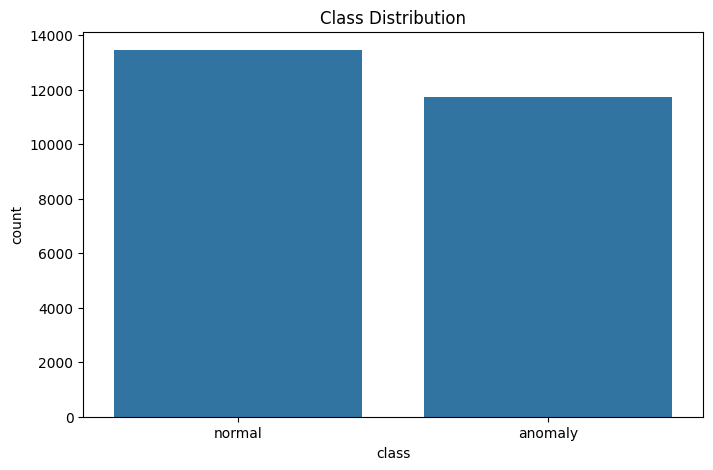

In [ ]:
# Visualize class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='class', data=df)
plt.title('Class Distribution')
plt.show()

In [ ]:

# Convert categorical columns to numerical
categorical_cols = ['protocol_type', 'service', 'flag']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Convert target variable to binary (0 for normal, 1 for anomaly)
df['class'] = df['class'].apply(lambda x: 0 if x == 'normal' else 1)

# Separate features and target
X = df.drop('class', axis=1)
y = df['class']

# Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape data for LSTM (samples, timesteps, features)
# Since we don't have sequential data, we'll treat each sample as a sequence of 1 timestep
X_reshaped = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance using SMOTE
# Note: We need to reshape back to 2D for SMOTE
X_train_2d = X_train.reshape(X_train.shape[0], X_train.shape[2])
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_2d, y_train)

# Reshape back to 3D for LSTM
X_train_smote = X_train_smote.reshape(X_train_smote.shape[0], 1, X_train_smote.shape[1])

print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())



Class distribution after SMOTE:
class
0    10759
1    10759
Name: count, dtype: int64


In [ ]:

def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
input_shape = (X_train_smote.shape[1], X_train_smote.shape[2])

# Create model
model = create_lstm_model(input_shape)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        27,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,097 (156.63 KB)

 Trainable params: 40,097 (156.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_lstm_model.h5', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    X_train_smote, y_train_smote,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
330/337 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8994 - loss: 0.3863

337/337 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9002 - loss: 0.3825 - val_accuracy: 0.9555 - val_loss: 0.1240
Epoch 2/50
332/337 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9634 - loss: 0.1049

337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9634 - loss: 0.1050 - val_accuracy: 0.9651 - val_loss: 0.1054
Epoch 3/50
335/337 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9674 - loss: 0.0967

337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9674 - loss: 0.0967 - val_accuracy: 0.9669 - val_loss: 0.0986
Epoch 4/50
335/337 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9690 - loss: 0.0870

337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9690 - loss: 0.0870 - val_accuracy: 0.9690 - val_loss: 0.0937
Epoch 5/50
334/337 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9740 - loss: 0.0751

337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9740 - loss: 0.0751 - val_accuracy: 0.9700 - val_loss: 0.0814
Epoch 6/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9730 - loss: 0.0703

337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9730 - loss: 0.0702 - val_accuracy: 0.9708 - val_loss: 0.0738
Epoch 7/50
333/337 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9761 - loss: 0.0573

337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9761 - loss: 0.0574 - val_accuracy: 0.9732 - val_loss: 0.0691
Epoch 8/50
336/337 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9728 - loss: 0.0578

337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9728 - loss: 0.0578 - val_accuracy: 0.9732 - val_loss: 0.0659
Epoch 9/50
335/337 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9751 - loss: 0.0561

337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9751 - loss: 0.0561 - val_accuracy: 0.9756 - val_loss: 0.0653
Epoch 10/50
327/337 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9772 - loss: 0.0535

337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9773 - loss: 0.0535 - val_accuracy: 0.9770 - val_loss: 0.0634
Epoch 11/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9774 - loss: 0.0526

337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9774 - loss: 0.0526 - val_accuracy: 0.9788 - val_loss: 0.0587
Epoch 12/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9811 - loss: 0.0476

337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9811 - loss: 0.0476 - val_accuracy: 0.9788 - val_loss: 0.0567
Epoch 13/50
330/337 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9806 - loss: 0.0475

337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9806 - loss: 0.0475 - val_accuracy: 0.9798 - val_loss: 0.0545
Epoch 14/50
332/337 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9816 - loss: 0.0456

337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9816 - loss: 0.0456 - val_accuracy: 0.9819 - val_loss: 0.0520
Epoch 15/50
332/337 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9811 - loss: 0.0444

337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9811 - loss: 0.0443 - val_accuracy: 0.9835 - val_loss: 0.0489
Epoch 16/50
330/337 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9819 - loss: 0.0428

337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9820 - loss: 0.0428 - val_accuracy: 0.9853 - val_loss: 0.0470
Epoch 17/50
333/337 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9836 - loss: 0.0385

337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9836 - loss: 0.0385 - val_accuracy: 0.9855 - val_loss: 0.0454
Epoch 18/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9840 - loss: 0.0383 - val_accuracy: 0.9855 - val_loss: 0.0455
Epoch 19/50
330/337 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9859 - loss: 0.0363

337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9860 - loss: 0.0362 - val_accuracy: 0.9873 - val_loss: 0.0431
Epoch 20/50
329/337 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9861 - loss: 0.0337

337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9861 - loss: 0.0337 - val_accuracy: 0.9875 - val_loss: 0.0418
Epoch 21/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9840 - loss: 0.0360 - val_accuracy: 0.9861 - val_loss: 0.0444
Epoch 22/50
326/337 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9868 - loss: 0.0331

337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9869 - loss: 0.0330 - val_accuracy: 0.9879 - val_loss: 0.0400
Epoch 23/50
326/337 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9874 - loss: 0.0306

337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9874 - loss: 0.0306 - val_accuracy: 0.9885 - val_loss: 0.0394
Epoch 24/50
327/337 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9872 - loss: 0.0314

337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9872 - loss: 0.0313 - val_accuracy: 0.9875 - val_loss: 0.0389
Epoch 25/50
334/337 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9873 - loss: 0.0286

337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9873 - loss: 0.0286 - val_accuracy: 0.9883 - val_loss: 0.0379
Epoch 26/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9883 - loss: 0.0270 - val_accuracy: 0.9877 - val_loss: 0.0386
Epoch 27/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9880 - loss: 0.0303 - val_accuracy: 0.9873 - val_loss: 0.0385
Epoch 28/50
330/337 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9896 - loss: 0.0269

337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9896 - loss: 0.0270 - val_accuracy: 0.9881 - val_loss: 0.0368
Epoch 29/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9868 - loss: 0.0295 - val_accuracy: 0.9881 - val_loss: 0.0384
Epoch 30/50
334/337 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9872 - loss: 0.0301

337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9873 - loss: 0.0301 - val_accuracy: 0.9885 - val_loss: 0.0365
Epoch 31/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9900 - loss: 0.0242 - val_accuracy: 0.9877 - val_loss: 0.0373
Epoch 32/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9892 - loss: 0.0251 - val_accuracy: 0.9875 - val_loss: 0.0376
Epoch 33/50
325/337 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9887 - loss: 0.0282

337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9887 - loss: 0.0281 - val_accuracy: 0.9879 - val_loss: 0.0358
Epoch 34/50
336/337 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9904 - loss: 0.0245

337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9904 - loss: 0.0245 - val_accuracy: 0.9889 - val_loss: 0.0348
Epoch 35/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9902 - loss: 0.0236 - val_accuracy: 0.9883 - val_loss: 0.0365
Epoch 36/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9897 - loss: 0.0254 - val_accuracy: 0.9887 - val_loss: 0.0351
Epoch 37/50
334/337 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9902 - loss: 0.0233

337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9902 - loss: 0.0234 - val_accuracy: 0.9907 - val_loss: 0.0346
Epoch 38/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9905 - loss: 0.0242 - val_accuracy: 0.9895 - val_loss: 0.0349
Epoch 39/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9915 - loss: 0.0215 - val_accuracy: 0.9905 - val_loss: 0.0362
Epoch 40/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9906 - loss: 0.0246 - val_accuracy: 0.9889 - val_loss: 0.0370
Epoch 41/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9916 - loss: 0.0226 - val_accuracy: 0.9891 - val_loss: 0.0364
Epoch 42/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9910 - loss: 0.0234 - val_accuracy: 0.9903 - val_loss: 0.0350


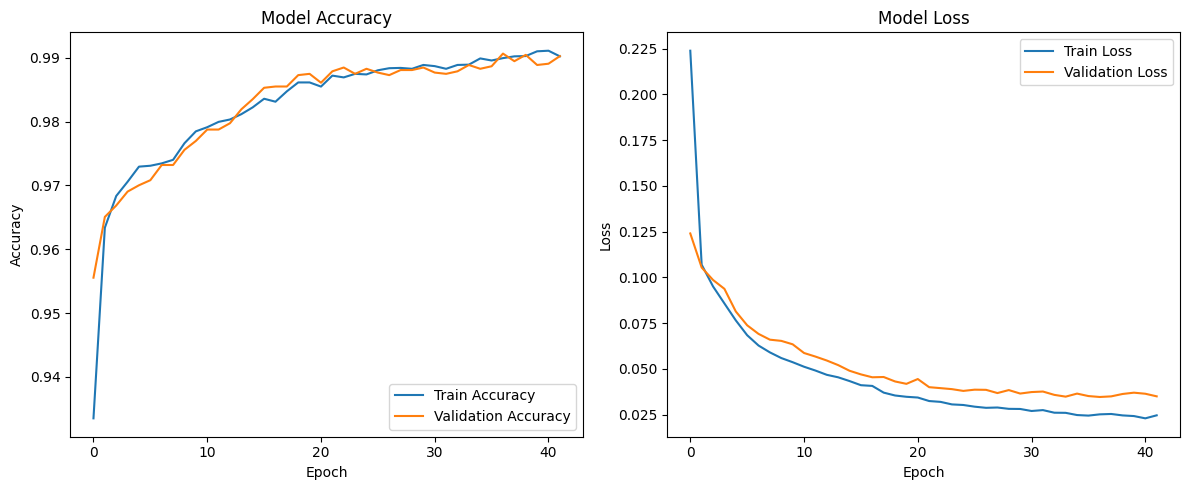

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99      2690
     Anomaly       0.99      0.99      0.99      2349

    accuracy                           0.99      5039
   macro avg       0.99      0.99      0.99      5039
weighted avg       0.99      0.99      0.99      5039



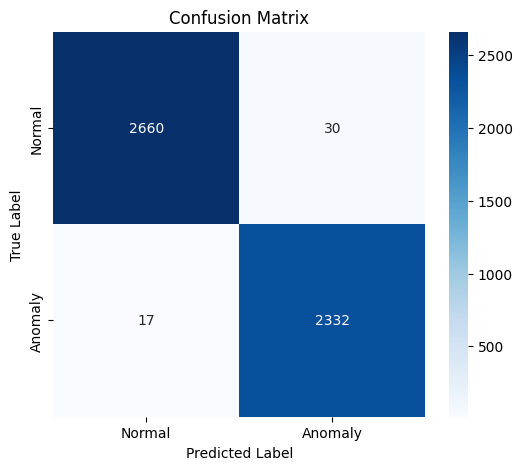

In [ ]:

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly']))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
xticklabels=['Normal', 'Anomaly'],
yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\n✅ Evaluation Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")


✅ Evaluation Metrics:
Accuracy : 0.9907
Precision: 0.9873
Recall : 0.9928
F1 Score : 0.9900


In [ ]:
!pip install rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=3fbb1be2fd867ab93b5741122e1d7909245d8fc404aab1e2f689189e1ac74ad8
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:

# Import required libraries
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Prepare ground truth and predictions for the anomaly detection task
y_true = ["normal" if label == "normal" else "anomaly" for label in y_test]
y_pred_label = ["normal" if pred > 0.5 else "anomaly" for pred in y_pred]

# BLEU Score with smoothing
reference_bleu = [[ref] for ref in y_true]
candidate_bleu = [[pred] for pred in y_pred_label]
smoothing_function = SmoothingFunction().method1
bleu = corpus_bleu(reference_bleu, candidate_bleu, smoothing_function=smoothing_function)

# ROUGE Scores
ref_text = " ".join(y_true)
cand_text = " ".join(y_pred_label)
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
rouge_scores = scorer.score(ref_text, cand_text)

# Classification Metrics
accuracy = accuracy_score(y_true, y_pred_label)
precision = precision_score(y_true, y_pred_label, pos_label="anomaly")
recall = recall_score(y_true, y_pred_label, pos_label="anomaly")
f1 = f1_score(y_true, y_pred_label, pos_label="anomaly")
class_report = classification_report(y_true, y_pred_label)

# Print all results
print(f"BLEU Score (with smoothing): {bleu:.4f}")
print(f"ROUGE-1: {rouge_scores['rouge1']}")
print(f"ROUGE-L: {rouge_scores['rougeL']}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(class_report)

BLEU Score (with smoothing): 0.0000
ROUGE-1: Score(precision=0.531256201627307, recall=0.531256201627307, fmeasure=0.531256201627307)
ROUGE-L: Score(precision=0.531256201627307, recall=0.531256201627307, fmeasure=0.531256201627307)
Accuracy: 0.5313
Precision: 1.0000
Recall: 0.5313
F1 Score: 0.6939

Classification Report:
              precision    recall  f1-score   support

     anomaly       1.00      0.53      0.69      5039
      normal       0.00      0.00      0.00         0

    accuracy                           0.53      5039
   macro avg       0.50      0.27      0.35      5039
weighted avg       1.00      0.53      0.69      5039



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


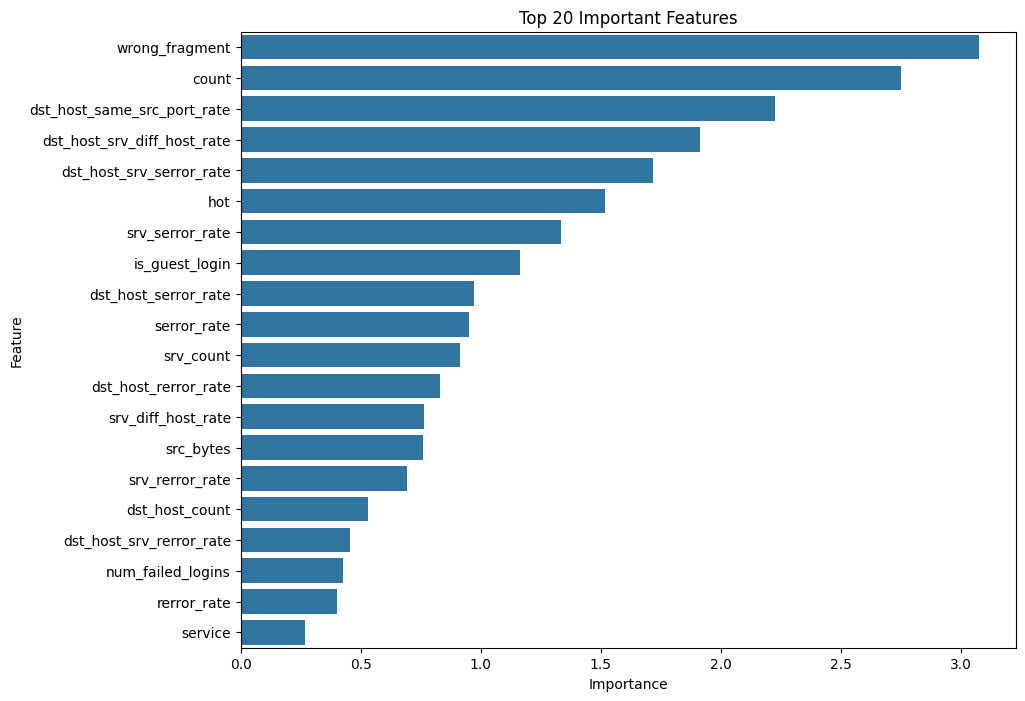

In [ ]:

# Create a simple model to get feature weights
simple_model = Sequential([
    Dense(1, activation='sigmoid', input_shape=(X_train_smote.shape[2],))
])
simple_model.compile(optimizer='adam', loss='binary_crossentropy')
simple_model.fit(X_train_smote.reshape(-1, X_train_smote.shape[2]), y_train_smote, epochs=10, verbose=0)

# Get feature weights
weights = simple_model.layers[0].get_weights()[0].flatten()
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': weights
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Important Features')
plt.show()

In [ ]:
feature_importance.head(20)

,Feature,Importance
7,wrong_fragment,3.074006
22,count,2.750024
35,dst_host_same_src_port_rate,2.227174
36,dst_host_srv_diff_host_rate,1.912863
38,dst_host_srv_serror_rate,1.717695
9,hot,1.516059
25,srv_serror_rate,1.333533
21,is_guest_login,1.162101
37,dst_host_serror_rate,0.970565
24,serror_rate,0.951435


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

# Ensure y_test and y_pred_prob are 1D arrays
y_test = np.ravel(y_test)  # Flatten to 1D if needed
y_pred_prob = np.ravel(y_pred_prob)  # Flatten to 1D if needed

# 1. Probability Distribution Plot (optimized)
plt.figure(figsize=(10, 6))


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<ipython-input-19-357a504e1269>:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


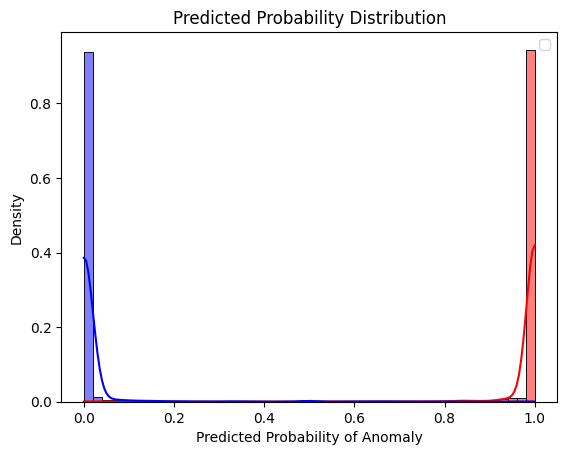

In [ ]:

# Create DataFrame with proper 1D arrays
plot_df = pd.DataFrame({
    'Probability': y_pred_prob,
    'Class': np.where(y_test == 0, 'Normal', 'Anomaly')
})

# Optional: Subsample if dataset is very large
if len(plot_df) > 10000:
    plot_df = plot_df.sample(10000, random_state=42)

sns.histplot(
    data=plot_df, x='Probability', hue='Class',
    palette={'Normal': 'blue', 'Anomaly': 'red'},
    kde=True,
    stat='probability',
    bins=50,
    common_norm=False
)

plt.title('Predicted Probability Distribution')
plt.xlabel('Predicted Probability of Anomaly')
plt.ylabel('Density')
plt.legend()
plt.show()


Threshold Analysis:
Default threshold (0.5): Accuracy = 0.9907
Optimal threshold (0.6893): Accuracy = 0.9909


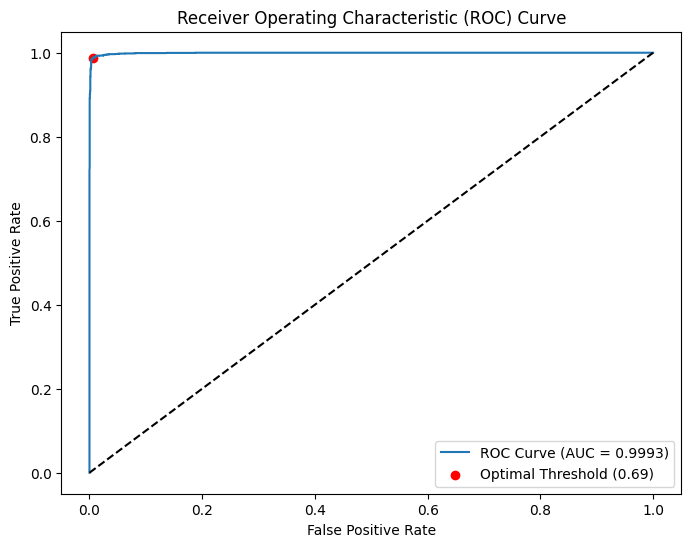

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]

print(f"\nThreshold Analysis:")
print(f"Default threshold (0.5): Accuracy = {accuracy_score(y_test, (y_pred_prob > 0.5).astype(int)):.4f}")
print(f"Optimal threshold ({optimal_threshold:.4f}): Accuracy = {accuracy_score(y_test, (y_pred_prob > optimal_threshold).astype(int)):.4f}")

# 3. ROC Curve Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_prob):.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.scatter(
    fpr[optimal_idx], tpr[optimal_idx],
    marker='o', color='red',
    label=f'Optimal Threshold ({optimal_threshold:.2f})'
)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [ ]:

import joblib

# Save the trained model
model.save('http_anomaly_detection_lstm.h5')

# Save preprocessing objects
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

print("Model and preprocessing objects saved successfully.")

Model and preprocessing objects saved successfully.


In [ ]:

def predict_anomaly(sample_data):
    """
    sample_data: A dictionary containing the raw feature values for one sample
    """
    # Create DataFrame with all features, fill missing with 0
    sample_df = pd.DataFrame([sample_data])

    # Get all feature names from the scaler
    feature_names = scaler.feature_names_in_

    # Add missing columns to the sample DataFrame and fill with 0
    missing_cols = set(feature_names) - set(sample_df.columns)
    for col in missing_cols:
        sample_df[col] = 0  # Fill missing numerical features with 0

    # Ensure columns are in the same order as during fitting
    sample_df = sample_df[feature_names]

    # Preprocess categorical features
    for col in categorical_cols:
        le = label_encoders[col]
        # Handle unknown values by replacing with the most frequent value
        if sample_df[col].dtype == 'object':  # Check if the column is categorical
            if sample_df[col][0] not in le.classes_:
                # If the value is unknown, replace it with the most frequent value
                # (assuming 'df' is your original DataFrame used for training)
                most_frequent_value = df[col].mode()[0]
                sample_df[col] = most_frequent_value

        sample_df[col] = le.transform(sample_df[col])  # Transform to numerical

    # Scale numerical features
    sample_scaled = scaler.transform(sample_df)

    # Reshape for LSTM
    sample_reshaped = sample_scaled.reshape(1, 1, sample_scaled.shape[1])

    # Make prediction
    prob = model.predict(sample_reshaped)[0][0]
    prediction = 1 if prob > 0.5 else 0

    return {
        'probability': float(prob),
        'prediction': 'Anomaly' if prediction == 1 else 'Normal',
        'threshold_used': 0.5
    }


In [ ]:

sample = {
    'duration': 0,
    'protocol_type': 'tcp',
    'service': 'http',
    'flag': 'SF',
    'src_bytes': 232,
    'dst_bytes': 8153,
    'land': 0,
    'wrong_fragment': 0,
    'urgent': 0,
    'hot': 0,
    'num_failed_logins': 0,
    'logged_in': 0,
    'num_compromised': 0,
    'root_shell': 0,
    'su_attempted': 0,
    'num_root': 0,
    'num_file_creations': 0,
    'num_shells': 0,
    'num_access_files': 0,
    'num_outbound_cmds': 0,
    'is_host_login': 0,
    'is_guest_login': 0,
    'count': 1,
    'srv_count': 1,
    'serror_rate': 0.0,
    'srv_serror_rate': 0.0,
    'rerror_rate': 0.0,
    'srv_rerror_rate': 0.0,
    'same_srv_rate': 1.0,
    'diff_srv_rate': 0.0,
    'srv_diff_host_rate': 0.0,
    'dst_host_count': 1,
    'dst_host_srv_count': 1,
    'dst_host_same_srv_rate': 1.0,
    'dst_host_diff_srv_rate': 0.0,
    'dst_host_same_src_port_rate': 1.0,
    'dst_host_srv_diff_host_rate': 0.0,
    'dst_host_serror_rate': 0.0,
    'dst_host_srv_serror_rate': 0.0,
    'dst_host_rerror_rate': 0.0,
    'dst_host_srv_rerror_rate': 0.0
}

result = predict_anomaly(sample)
print(result)

sample2 = {
    'duration': 10,
    'protocol_type': 'udp',
    'service': 'domain_u',
    'flag': 'SF',
    'src_bytes': 100,
    'dst_bytes': 500,
    'land': 0,
    'wrong_fragment': 0,
    'urgent': 0,
    'hot': 0,
    'num_failed_logins': 0,
    'logged_in': 0,
    'num_compromised': 0,
    'root_shell': 0,
    'su_attempted': 0,
    'num_root': 0,
    'num_file_creations': 0,
    'num_shells': 0,
    'num_access_files': 0,
    'num_outbound_cmds': 0,
    'is_host_login': 0,
    'is_guest_login': 0,
    'count': 1,
    'srv_count': 1,
    'serror_rate': 0.0,
    'srv_serror_rate': 0.0,
    'rerror_rate': 0.0,
    'srv_rerror_rate': 0.0,
    'same_srv_rate': 1.0,
    'diff_srv_rate': 0.0,
    'srv_diff_host_rate': 0.0,
    'dst_host_count': 1,
    'dst_host_srv_count': 1,
    'dst_host_same_srv_rate': 1.0,
    'dst_host_diff_srv_rate': 0.0,
    'dst_host_same_src_port_rate': 1.0,
    'dst_host_srv_diff_host_rate': 0.0,
    'dst_host_serror_rate': 0.0,
    'dst_host_srv_serror_rate': 0.0,
    'dst_host_rerror_rate': 0.0,
    'dst_host_srv_rerror_rate': 0.0
}

result2 = predict_anomaly(sample2)
print(result2)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
{'probability': 0.6083170175552368, 'prediction': 'Anomaly', 'threshold_used': 0.5}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
{'probability': 0.012753261253237724, 'prediction': 'Normal', 'threshold_used': 0.5}


In [ ]:
sample_01 = {
    'duration': 10,
    'protocol_type': 'udp',
    'service': 'domain_u',
    'flag': 'SF',
    'src_bytes': 100,
    'dst_bytes': 500,
    'land': 0,
    'wrong_fragment': 0,
    'urgent': 0,
    'hot': 0,
    'num_failed_logins': 0,
    'logged_in': 1,
    'num_compromised': 0,
    'root_shell': 0,
    'su_attempted': 0,
    'num_root': 0,
    'num_file_creations': 0,
    'num_shells': 0,
    'num_access_files': 0,
    'num_outbound_cmds': 0,
    'is_host_login': 1,
    'is_guest_login': 0,
    'count': 10,
    'srv_count': 1,
    'serror_rate': 0.0,
    'srv_serror_rate': 0.0,
    'rerror_rate': 0.0,
    'srv_rerror_rate': 0.0,
    'same_srv_rate': 1.0,
    'diff_srv_rate': 0.0,
    'srv_diff_host_rate': 0.0,
    'dst_host_count': 1,
    'dst_host_srv_count': 1,
    'dst_host_same_srv_rate': 1.0,
    'dst_host_diff_srv_rate': 0.0,
    'dst_host_same_src_port_rate': 1.0,
    'dst_host_srv_diff_host_rate': 0.0,
    'dst_host_serror_rate': 0.0,
    'dst_host_srv_serror_rate': 0.0,
    'dst_host_rerror_rate': 0.0,
    'dst_host_srv_rerror_rate': 0.0
}

print(predict_anomaly(sample_01))  # Expected Output: "Normal"


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
{'probability': 0.04712818190455437, 'prediction': 'Normal', 'threshold_used': 0.5}


In [ ]:
sample_02 = {
    'duration': 200,
    'protocol_type': 'icmp',
    'service': 'ecr_i',
    'flag': 'REJ',
    'src_bytes': 0,
    'dst_bytes': 0,
    'land': 1,
    'wrong_fragment': 3,
    'urgent': 2,
    'hot': 5,
    'num_failed_logins': 4,
    'logged_in': 0,
    'num_compromised': 10,
    'root_shell': 1,
    'su_attempted': 1,
    'num_root': 5,
    'num_file_creations': 4,
    'num_shells': 1,
    'num_access_files': 3,
    'num_outbound_cmds': 0,
    'is_host_login': 1,
    'is_guest_login': 1,
    'count': 100,
    'srv_count': 100,
    'serror_rate': 1.0,
    'srv_serror_rate': 1.0,
    'rerror_rate': 0.9,
    'srv_rerror_rate': 0.8,
    'same_srv_rate': 0.1,
    'diff_srv_rate': 0.9,
    'srv_diff_host_rate': 0.8,
    'dst_host_count': 100,
    'dst_host_srv_count': 100,
    'dst_host_same_srv_rate': 0.1,
    'dst_host_diff_srv_rate': 0.9,
    'dst_host_same_src_port_rate': 0.05,
    'dst_host_srv_diff_host_rate': 0.9,
    'dst_host_serror_rate': 1.0,
    'dst_host_srv_serror_rate': 1.0,
    'dst_host_rerror_rate': 0.9,
    'dst_host_srv_rerror_rate': 0.8
}
print(predict_anomaly(sample_02))  # Expected Output: "Anomalous"


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
{'probability': 1.0, 'prediction': 'Anomaly', 'threshold_used': 0.5}


In [ ]:
sample_01 = {
    'duration': 10,
    'protocol_type': 'udp',
    'service': 'domain_u',
    'flag': 'SF',
    'src_bytes': 100,
    'dst_bytes': 500,
    'land': 0,
    'wrong_fragment': 0,
    'urgent': 0,
    'hot': 0,
    'num_failed_logins': 0,
    'logged_in': 1,
    'num_compromised': 0,
    'root_shell': 0,
    'su_attempted': 0,
    'num_root': 0,
    'num_file_creations': 0,
    'num_shells': 0,
    'num_access_files': 0,
    'num_outbound_cmds': 0,
    'is_host_login': 0,
    'is_guest_login': 0,
    'count': 10,
    'srv_count': 1,
    'serror_rate': 0.0,
    'srv_serror_rate': 0.0,
    'rerror_rate': 0.0,
    'srv_rerror_rate': 0.0,
    'same_srv_rate': 1.0,
    'diff_srv_rate': 0.0,
    'srv_diff_host_rate': 0.0,
    'dst_host_count': 1,
    'dst_host_srv_count': 1,
    'dst_host_same_srv_rate': 1.0,
    'dst_host_diff_srv_rate': 0.0,
    'dst_host_same_src_port_rate': 1.0,
    'dst_host_srv_diff_host_rate': 0.0,
    'dst_host_serror_rate': 0.0,
    'dst_host_srv_serror_rate': 0.0,
    'dst_host_rerror_rate': 0.0,
    'dst_host_srv_rerror_rate': 0.0
}

print(predict_anomaly(sample_01))  # Expected Output: "Normal"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
{'probability': 0.0193299800157547, 'prediction': 'Normal', 'threshold_used': 0.5}
